## Epipolar Geometry


Often in multiple view geometry, there are interesting relationships between the multiple cameras, a 3D point, and that point’s projections in each of the camera’s image plane. The geometry that relates the cameras, points in 3D, and the corresponding observations is referred to as the epipolar geometry of a stereo pair..

<img src = Images/epipolar.png style="width:400px;height:300px">

## Fundamental Matrix Estimation

In computer vision, the fundamental matrix F is a 3×3 matrix which relates corresponding points in stereo images. In epipolar geometry, with homogeneous image coordinates, x and x′, of corresponding points in a stereo image pair, Fx describes a line (an epipolar line) on which the corresponding point x′ on the other image must lie. 

For this assignment, given the images below, your task is to calculate the fundamental matrix that relates these images.

<img src = Images/buildingA.png style="width:400px;height:200px">

<img src = Images/buildingB.png style="width:400px;height:200px">

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images of buildingA and buildingB
imageA_path = "./Images/buildingA.png"  # buildingA image
imageB_path = "./Images/buildingB.png"  # buildingB image

imgA = cv2.imread(imageA_path, cv2.IMREAD_GRAYSCALE)
imgB = cv2.imread(imageB_path, cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect key points and compute descriptors
keypointsA, descriptorsA = sift.detectAndCompute(imgA, None)
keypointsB, descriptorsB = sift.detectAndCompute(imgB, None)

# Match features using Brute-Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptorsA, descriptorsB)
matches = sorted(matches, key=lambda x: x.distance)  # Sort matches by distance

# Extract the matched points
ptsA = np.float32([keypointsA[m.queryIdx].pt for m in matches])
ptsB = np.float32([keypointsB[m.trainIdx].pt for m in matches])

# Estimate the Fundamental Matrix
F, mask = cv2.findFundamentalMat(ptsA, ptsB, cv2.FM_RANSAC)

# Select only inlier points
inlier_ptsA = ptsA[mask.ravel() == 1]
inlier_ptsB = ptsB[mask.ravel() == 1]

# Visualize the matches and fundamental matrix
output_data = {
    "Fundamental Matrix": F,
    "Matched Points (Image A)": inlier_ptsA,
    "Matched Points (Image B)": inlier_ptsB
}

output_data


{'Fundamental Matrix': array([[ 9.73431331e-05,  6.27661244e-04, -3.53567492e-01],
        [-7.49905576e-04,  9.74964820e-06,  3.87664712e-01],
        [ 2.87651265e-01, -3.14218677e-01,  1.00000000e+00]]),
 'Matched Points (Image A)': array([[691.4231  , 395.76212 ],
        [661.17865 , 427.39713 ],
        [661.17865 , 427.39713 ],
        [645.027   , 416.06445 ],
        [113.60872 , 417.96332 ],
        [705.79834 , 402.99478 ],
        [525.3634  , 435.70193 ],
        [115.5065  , 356.84708 ],
        [721.0088  , 402.84073 ],
        [615.613   , 464.45523 ],
        [608.9685  , 343.21466 ],
        [634.43335 , 447.9234  ],
        [566.1609  , 414.62653 ],
        [625.7724  , 412.78668 ],
        [543.58417 , 482.66772 ],
        [407.0937  , 428.8692  ],
        [628.68604 , 443.03885 ],
        [130.60423 , 454.22958 ],
        [535.7154  , 489.74292 ],
        [348.57782 , 462.59927 ],
        [ 66.52609 , 358.03    ],
        [364.49896 , 412.8454  ],
        [502.2109

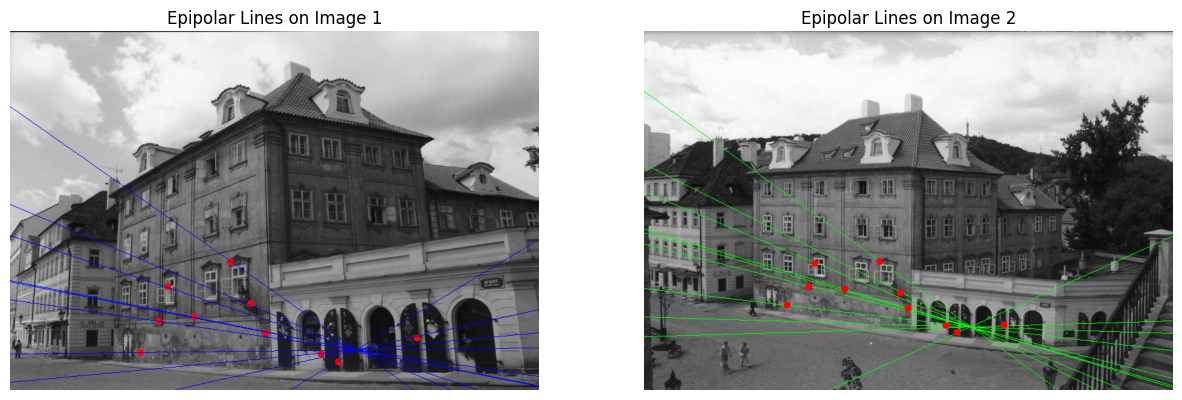

In [2]:
# Draw matches and epipolar lines for the given assignment
def draw_epipolar_lines(img1, img2, pts1, pts2, F):
    """
    Draw epipolar lines and points on the images.
    :param img1: First image (grayscale)
    :param img2: Second image (grayscale)
    :param pts1: Points in the first image
    :param pts2: Corresponding points in the second image
    :param F: Fundamental matrix
    """
    # Convert images to RGB for visualization
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Randomly sample 10 points
    np.random.seed(0)  # For reproducibility
    sampled_indices = np.random.choice(len(pts1), 10)
    sampled_pts1 = pts1[sampled_indices]
    sampled_pts2 = pts2[sampled_indices]

    # Draw epipolar lines on the second image
    for pt1 in sampled_pts1:
        line = np.dot(F, np.append(pt1, 1))  # Epipolar line equation
        a, b, c = line
        x0, y0 = 0, int(-c / b)  # Line at x=0
        x1, y1 = img2.shape[1], int(-(c + a * img2.shape[1]) / b)  # Line at x=width
        img2_rgb = cv2.line(img2_rgb, (x0, y0), (x1, y1), (0, 255, 0), 1)
        img1_rgb = cv2.circle(img1_rgb, tuple(pt1.astype(int)), 5, (0, 0, 255), -1)

    # Draw epipolar lines on the first image
    for pt2 in sampled_pts2:
        line = np.dot(F.T, np.append(pt2, 1))  # Epipolar line equation
        a, b, c = line
        x0, y0 = 0, int(-c / b)  # Line at x=0
        x1, y1 = img1.shape[1], int(-(c + a * img1.shape[1]) / b)  # Line at x=width
        img1_rgb = cv2.line(img1_rgb, (x0, y0), (x1, y1), (255, 0, 0), 1)
        img2_rgb = cv2.circle(img2_rgb, tuple(pt2.astype(int)), 5, (0, 0, 255), -1)

    # Display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(img1_rgb[:, :, ::-1])  # Convert BGR to RGB for plt
    axes[0].set_title("Epipolar Lines on Image 1")
    axes[0].axis("off")

    axes[1].imshow(img2_rgb[:, :, ::-1])  # Convert BGR to RGB for plt
    axes[1].set_title("Epipolar Lines on Image 2")
    axes[1].axis("off")

    plt.show()


# Draw epipolar lines on the images
draw_epipolar_lines(imgA, imgB, inlier_ptsA, inlier_ptsB, F)


### Import Libraries and Load Images

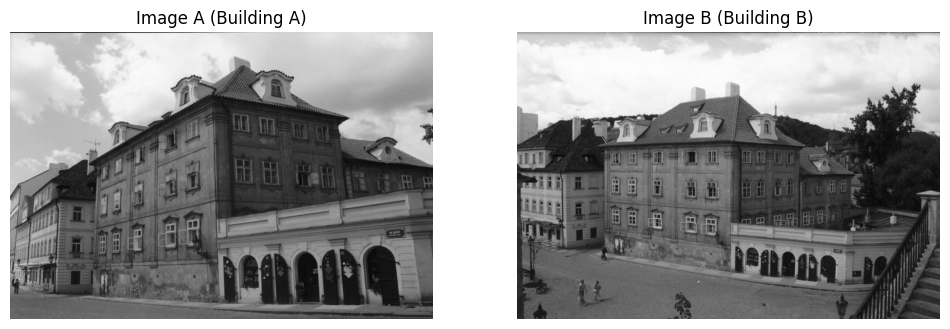

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the images of buildingA and buildingB
imgA = cv2.imread("./Images/buildingA.png", cv2.IMREAD_GRAYSCALE)  
imgB = cv2.imread("./Images/buildingB.png", cv2.IMREAD_GRAYSCALE)  

# Display the input images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imgA, cmap='gray')
plt.title("Image A (Building A)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(imgB, cmap='gray')
plt.title("Image B (Building B)")
plt.axis("off")
plt.show()


### Find Keypoints and Correspondences

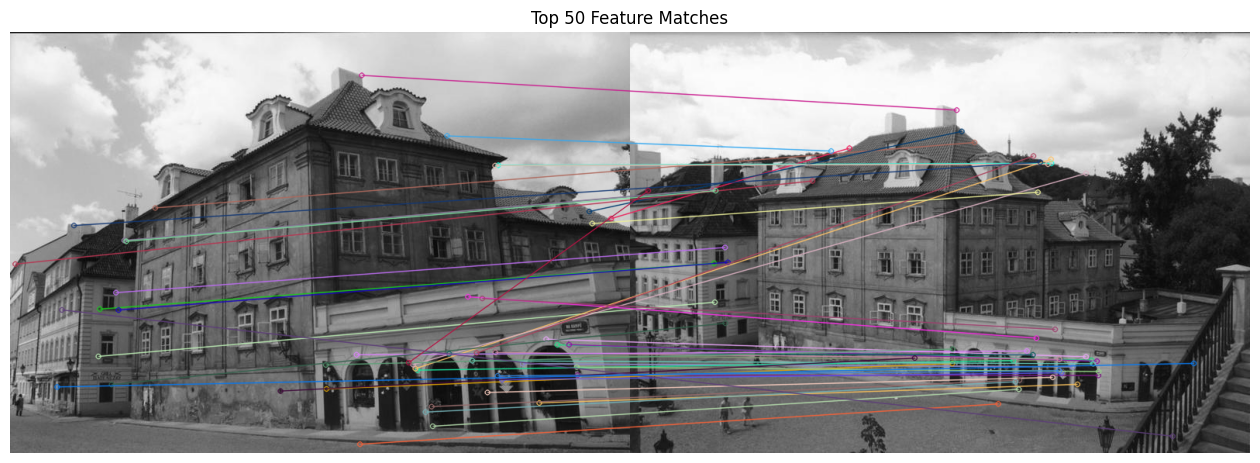

In [4]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect key points and compute descriptors
keypointsA, descriptorsA = sift.detectAndCompute(imgA, None)
keypointsB, descriptorsB = sift.detectAndCompute(imgB, None)

# Match features using Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptorsA, descriptorsB)

# Sort matches by distance (good matches come first)
matches = sorted(matches, key=lambda x: x.distance)

# Extract matched points
ptsA = np.float32([keypointsA[m.queryIdx].pt for m in matches])
ptsB = np.float32([keypointsB[m.trainIdx].pt for m in matches])

# Visualize the matched points
matched_img = cv2.drawMatches(imgA, keypointsA, imgB, keypointsB, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 8))
plt.imshow(matched_img)
plt.title("Top 50 Feature Matches")
plt.axis("off")
plt.show()


### Compute the Fundamental Matrix

In [5]:
# Estimate the fundamental matrix using RANSAC
F, mask = cv2.findFundamentalMat(ptsA, ptsB, cv2.FM_RANSAC)

# Select inlier points
inlier_ptsA = ptsA[mask.ravel() == 1]
inlier_ptsB = ptsB[mask.ravel() == 1]

# Display the fundamental matrix
print("Fundamental Matrix (F):\n", F)


Fundamental Matrix (F):
 [[ 9.73431331e-05  6.27661244e-04 -3.53567492e-01]
 [-7.49905576e-04  9.74964820e-06  3.87664712e-01]
 [ 2.87651265e-01 -3.14218677e-01  1.00000000e+00]]


### Draw Epipolar Lines

In [6]:
# Function to draw epipolar lines and sampled points
def draw_epipolar_lines(img1, img2, pts1, pts2, F):
    """
    Draw epipolar lines and points on the images.
    :param img1: First image (grayscale)
    :param img2: Second image (grayscale)
    :param pts1: Points in the first image
    :param pts2: Corresponding points in the second image
    :param F: Fundamental matrix
    """
    # Convert images to RGB for visualization
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    # Randomly sample 10 points
    np.random.seed(0)  # For reproducibility
    sampled_indices = np.random.choice(len(pts1), 10, replace=True)
    sampled_pts1 = pts1[sampled_indices]
    sampled_pts2 = pts2[sampled_indices]

    # Draw epipolar lines on the second image
    for pt1 in sampled_pts1:
        line = np.dot(F, np.append(pt1, 1))  # Epipolar line equation
        a, b, c = line
        x0, y0 = 0, int(-c / b)  # Line at x=0
        x1, y1 = img2.shape[1], int(-(c + a * img2.shape[1]) / b)  # Line at x=width
        img2_rgb = cv2.line(img2_rgb, (x0, y0), (x1, y1), (0, 255, 0), 1)
        img1_rgb = cv2.circle(img1_rgb, tuple(pt1.astype(int)), 5, (0, 0, 255), -1)

    # Draw epipolar lines on the first image
    for pt2 in sampled_pts2:
        line = np.dot(F.T, np.append(pt2, 1))  # Epipolar line equation
        a, b, c = line
        x0, y0 = 0, int(-c / b)  # Line at x=0
        x1, y1 = img1.shape[1], int(-(c + a * img1.shape[1]) / b)  # Line at x=width
        img1_rgb = cv2.line(img1_rgb, (x0, y0), (x1, y1), (255, 0, 0), 1)
        img2_rgb = cv2.circle(img2_rgb, tuple(pt2.astype(int)), 5, (0, 0, 255), -1)

    # Display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(img1_rgb[:, :, ::-1])  
    axes[0].set_title("Epipolar Lines on Image 1")
    axes[0].axis("off")

    axes[1].imshow(img2_rgb[:, :, ::-1])  
    axes[1].set_title("Epipolar Lines on Image 2")
    axes[1].axis("off")

    plt.show()


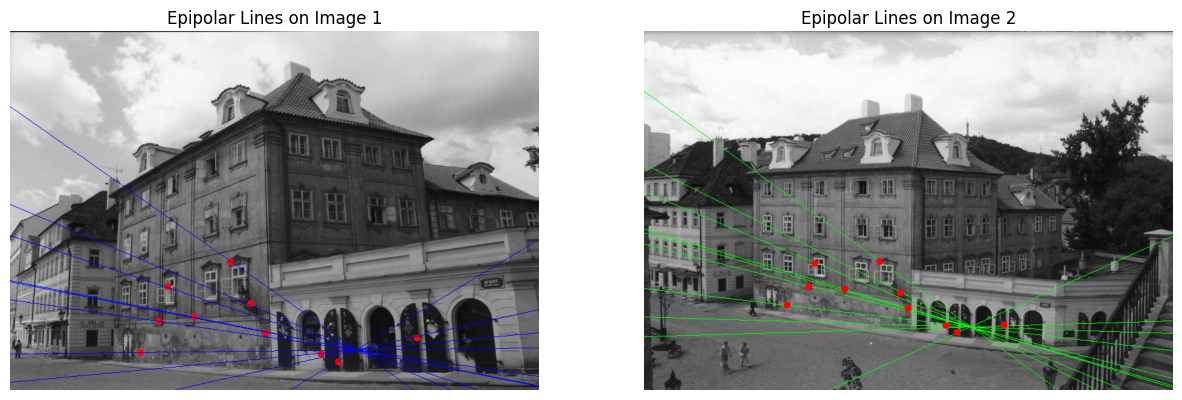

In [7]:
# Draw the epipolar lines
draw_epipolar_lines(imgA, imgB, inlier_ptsA, inlier_ptsB, F)

## Perform the tasks below step by step to calculate the fundamental matrix and draw the epipolar lines:

    1. Find keypoints and correspondences between two images (you may use SIFT/SURF/ORB etc). If the matched correspondences are noisy, the fundamental matrix calculation won't be correct. Therefore, you should find some good matches between the pair of images.
    2. Compute the fundamental matrix, F using the 8 point algorithm.
    3. For the points in the first image, their corresponding points in second image will lie on the epipolar line. Randomly sample 10 points from the correspondences you have detected and draw these points on the images along with thier epipolar lines. 
    
